In [1]:
import vizdoom as vzd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
possible_actions = np.zeros((8,6),dtype=int).tolist()
possible_actions[0] = [1,0,0,0,0]
possible_actions[1] = [0,1,0,0,0]
possible_actions[2] = [0,0,-45,0,0]
possible_actions[3] = [0,0,45,0,0]
possible_actions[4] = [0,0,0,50,0]
possible_actions[5] = [0,0,0,-50,0]
possible_actions[6] = [0,0,0,0,30]
possible_actions[7] = [0,0,0,0,-30]
possible_actions

[[1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, -45, 0, 0],
 [0, 0, 45, 0, 0],
 [0, 0, 0, 50, 0],
 [0, 0, 0, -50, 0],
 [0, 0, 0, 0, 30],
 [0, 0, 0, 0, -30]]

Found
[751.49317932 141.93869019   0.          27.12524415]
[751.49317932 141.93869019   0.         342.12524422]


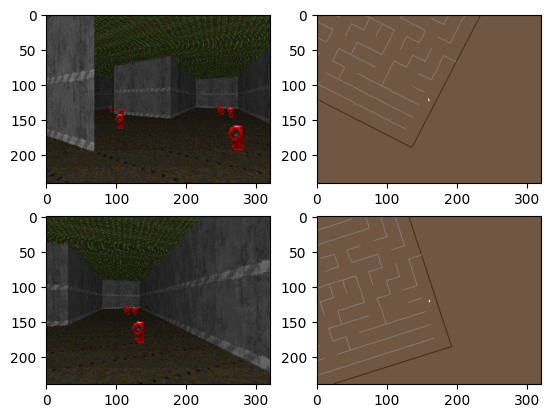

In [36]:
from matplotlib import pyplot as plt

game = vzd.DoomGame()
game.load_config('../resources/temp_maps/datagen.cfg')
game.set_doom_scenario_path('../data/maps_manykeys_aug/30x30.wad')

game.set_automap_mode(vzd.AutomapMode.WHOLE)
# game.set_seed(24)
game.set_render_hud(False)
game.set_objects_info_enabled(True)
game.set_screen_format(vzd.ScreenFormat.RGB24)
game.set_labels_buffer_enabled(True)
game.set_render_corpses(True)
game.set_doom_map('map04')
game.init()
game.new_episode()
game.get_state()

st1 = game.get_state()

cam1 = st1.screen_buffer
#print(len(st1.objects))

for obj in st1.objects:
    if obj.name == 'RedCard':
        if obj.id == 0:
            print('Found')

mp1 = st1.automap_buffer

var1 = st1.game_variables

print(var1)

game.make_action([0,0, 45, 0, 0], 1)

st2 = game.get_state()

var2 = st2.game_variables

print(var2)

cam2 = st2.screen_buffer

mp2 = st2.automap_buffer

fig, axs = plt.subplots(2, 2)

axs[0, 0].imshow(cam1)
axs[0, 1].imshow(mp1)
axs[1, 0].imshow(cam2)
axs[1, 1].imshow(mp2)

plt.show()

game.close()






In [42]:
data = np.load('data/maps_manykeys_aug/processed/map4_data.npz', allow_pickle=True)
data["objects"]

array([{'x': 158.13491821289062, 'y': 1012.7411346435547, 'z': 0.0, 'angle': 180.00000004190952}],
      dtype=object)

In [5]:
def color_transform(raw_map: np.array):
    map = raw_map.copy()
    
    # Create mask for gray colors (where all RGB values are similar)
    gray_mask = (abs(raw_map[:,:,0] - raw_map[:,:,1]) < 10) & (abs(raw_map[:,:,1] - raw_map[:,:,2]) < 10)
    
    # Create mask for dark brown colors (where R value is low)
    dark_brown_mask = (raw_map[:,:,0] < 100) & (raw_map[:,:,1] < 80) & (raw_map[:,:,2] < 60)
    
    # Set dark browns and grays to black
    map[gray_mask | dark_brown_mask] = [0, 0, 0]
    
    # Set everything else (background browns) to white
    map[~(gray_mask | dark_brown_mask)] = [255, 255, 255]
    
    # Keep the red marker if needed
    map[118:121,158:161,:] = [255,0,0]
    
    return map



In [6]:
def tracing(raw_map: np.array):
    # Create a copy and get center coordinates
    map = raw_map.copy()
    center_y, center_x = 119, 159
    
    # Pre-allocate result array
    result = np.full_like(map, 255)
    
    # Get wall coordinates in upper half
    wall_coords = np.where((map[:center_y] != [255,255,255]).all(axis=2))
    
    # Vectorized direction calculations
    dx = wall_coords[1] - center_x 
    dy = wall_coords[0] - center_y
    distances = np.sqrt(dx*dx + dy*dy).astype(int)
    steps = np.maximum(distances * 2, 1)
    
    # Process each wall point
    for i in range(len(wall_coords[0])):
        y, x = wall_coords[0][i], wall_coords[1][i]
        
        # Calculate ray steps
        step_x = dx[i] / steps[i]
        step_y = dy[i] / steps[i]
        
        # Ray positions
        ray_x = center_x + np.arange(steps[i]) * step_x
        ray_y = center_y + np.arange(steps[i]) * step_y
        
        # Round to integer coordinates
        check_x = np.round(ray_x).astype(int)
        check_y = np.round(ray_y).astype(int)
        
        # Check if ray hits any walls
        is_visible = True
        for j in range(steps[i]):
            if (check_y[j], check_x[j]) != (y,x) and np.all(map[check_y[j], check_x[j]] == [0,0,0]):
                is_visible = False
                break
                
        result[y,x] = [0,0,0] if is_visible else [255,255,255]
    
    # Add red marker
    result[118:121, 158:161] = [255,0,0]
    
    return result

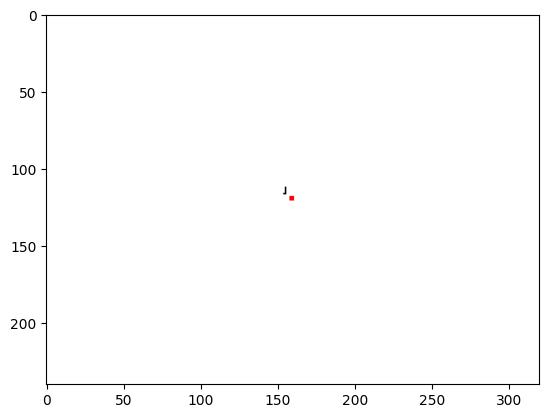

In [7]:
plt.imshow(tracing(color_transform(mp1)))
plt.show()

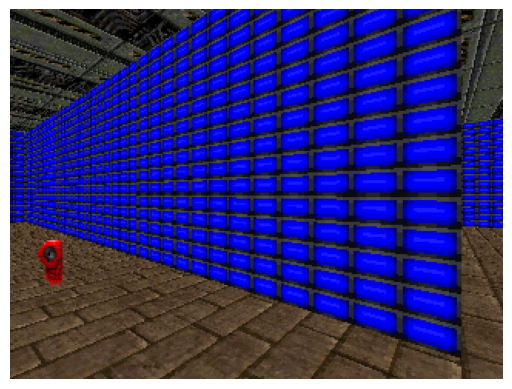

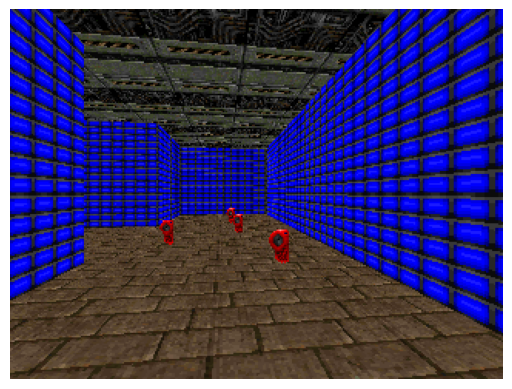

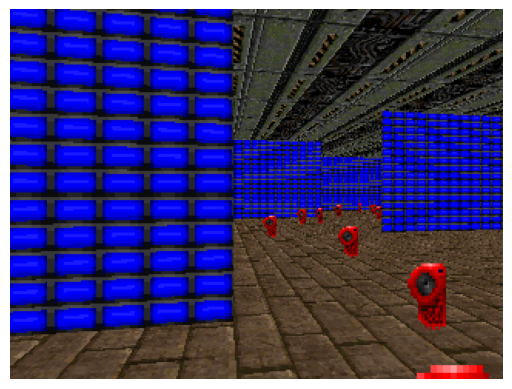

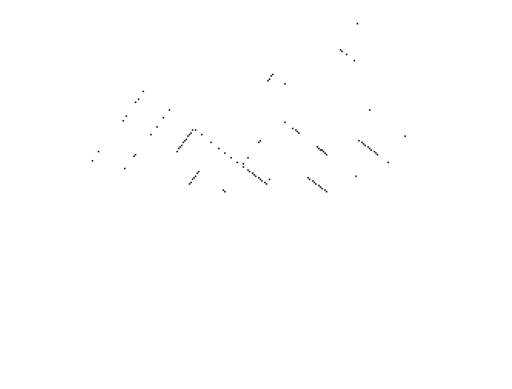

In [18]:
import numpy as np
from matplotlib import pyplot as plt
data = np.load('../data/maps_manykeys_aug/processed/map2_data.npz', allow_pickle=True)
data["images"].shape
for im in data["images"][0][0][0]:
    plt.imshow(im)
    plt.axis('off')
    plt.show()
plt.imshow(data["maps"][0][0][0])
plt.axis('off')
plt.show()


